In [1]:
library(tidyverse)
library(tigris)
library(tidymodels)
options(tigris_use_cache = T)
options(repr.plot.height=4, repr.plot.width=10)
theme_set(theme_classic())

── Attaching core tidyverse packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
To enable caching of data, set `options(tigris_use_cache = TRUE)`
in your R script or .Rprofile.

── Attaching packages ───────────────────────────────────────────────────

# STATS 504
## Week 15.2: Predicting air quality

In [2]:
load("aqi_2020_q1.RData")
# load(url("https://github.com/terhorst/stats504/raw/refs/heads/main/lectures/week15/aqi_2020_q1_sub.RData"))

## Geospatial prediction

- To improve our predictor from last lecture, we can share information from nearby sites.
- As well as incorporate additional lags prediction model.

## Determining nearby neighbors
- For each station, compute the $k$ stations that are nearest to it.
- How to calculate the neighbors?

In [3]:
stations <- aqi_2020_q1 %>% select(AQSID, Latitude, Longitude) %>% 
    distinct(AQSID, .keep_all = T)

In [4]:
knn <- list()

k <- 5

for (i in 1:nrow(stations)) {
    stn <- stations$AQSID[i]
    dst <- mutate(stations, dist = (Latitude - Latitude[i])^2 + (Longitude - Longitude[i])^2) %>% 
        top_n(k + 1, -dist) %>% filter(dist > 0)
    knn[[stn]] = dst$AQSID
    break
}

knn

$NRB000043
[1] "NRB000042" "NRB000045" "NRB000068" "NRB000055" "NRB000046"

In [5]:
library(geosphere)

M <- distm(stations[,c("Longitude", "Latitude")])

In [6]:
k = 5
nearest_neighbors <- apply(M, 1, order)[2:(k+1), ]

In [7]:
stns <- stations$AQSID[t(nearest_neighbors)]
dim(stns) <- dim(t(nearest_neighbors))
stns <- stns %>% as.data.frame %>% setNames(paste0("nn", 1:5))
st_knn <- cbind(stations, stns)

In [8]:
st_knn %>% head

,AQSID,Latitude,Longitude,nn1,nn2,nn3,nn4,nn5
,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
1,NRB000043,-1.280000,36.82000,NRB000046,NRB000055,NRB000045,NRB000042,NRB000068
2,NRB000042,-1.311220,36.87311,NRB000045,NRB000043,NRB000046,NRB000055,NRB000068
3,483951076,31.168889,-96.48194,480415011,483091037,483491081,483095010,483311075
4,080699991,40.277800,-105.54530,080690007,080130014,080131001,080130009,080130003
5,NRB000045,-1.253111,36.85653,NRB000043,NRB000046,NRB000042,NRB000055,NRB000068
6,530639995,47.808226,-117.34327,530630046,530630047,530630021,530639997,530630052


In [9]:
aqi_2020_q1 %>% mutate(AQI=pmax(OZONE_AQI, PM10_AQI, PM25_AQI, NO2_AQI, na.rm=T)) %>% 
    select(AQSID, Timestamp, AQI) %>% 
    distinct(AQSID, Timestamp, .keep_all = T) -> df

In [10]:
df %>% left_join(st_knn) -> df_merge

Joining with `by = join_by(AQSID)`


In [11]:
df_merge %>% 
    left_join(df, join_by(Timestamp, nn1 == AQSID), suffix=c(".base", ".nn1"), keep=F) %>% 
    rename(AQI = AQI.base) %>% 
    head

AQSID,Timestamp,AQI,Latitude,Longitude,nn1,nn2,nn3,nn4,nn5,AQI.nn1
<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
NRB000043,2020-01-01,NA,-1.280000,36.82000,NRB000046,NRB000055,NRB000045,NRB000042,NRB000068,NA
NRB000042,2020-01-01,NA,-1.311220,36.87311,NRB000045,NRB000043,NRB000046,NRB000055,NRB000068,NA
483951076,2020-01-01,NA,31.168889,-96.48194,480415011,483091037,483491081,483095010,483311075,NA
080699991,2020-01-01,NA,40.277800,-105.54530,080690007,080130014,080131001,080130009,080130003,46
NRB000045,2020-01-01,NA,-1.253111,36.85653,NRB000043,NRB000046,NRB000042,NRB000055,NRB000068,NA
530639995,2020-01-01,6,47.808226,-117.34327,530630046,530630047,530630021,530639997,530630052,NA


In [12]:
for (i in 1:5) {
    col_name <- paste0("nn", i)
    df_merge <- left_join(df_merge, df, join_by(Timestamp, {{ col_name }} == AQSID), 
                          suffix=c(".base", paste0(".", col_name)), keep=F) %>% 
        rename(AQI = AQI.base)
}

In [13]:
df_merge %>% head

AQSID,Timestamp,AQI,Latitude,Longitude,nn1,nn2,nn3,nn4,nn5,AQI.nn1,AQI.nn2,AQI.nn3,AQI.nn4,AQI.nn5
<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NRB000043,2020-01-01,NA,-1.280000,36.82000,NRB000046,NRB000055,NRB000045,NRB000042,NRB000068,NA,NA,NA,NA,NA
NRB000042,2020-01-01,NA,-1.311220,36.87311,NRB000045,NRB000043,NRB000046,NRB000055,NRB000068,NA,NA,NA,NA,NA
483951076,2020-01-01,NA,31.168889,-96.48194,480415011,483091037,483491081,483095010,483311075,NA,33,NA,NA,NA
080699991,2020-01-01,NA,40.277800,-105.54530,080690007,080130014,080131001,080130009,080130003,46,31,NA,NA,45
NRB000045,2020-01-01,NA,-1.253111,36.85653,NRB000043,NRB000046,NRB000042,NRB000055,NRB000068,NA,NA,NA,NA,NA
530639995,2020-01-01,6,47.808226,-117.34327,530630046,530630047,530630021,530639997,530630052,NA,13,10,11,NA


In [14]:
aqi.data <- df_merge %>% 
    group_by(AQSID) %>% arrange(AQSID, Timestamp) %>% 
    mutate(AQI_fut = lead(AQI, 24)) %>% 
    ungroup

aqi.data %>% head

AQSID,Timestamp,AQI,Latitude,Longitude,nn1,nn2,nn3,nn4,nn5,AQI.nn1,AQI.nn2,AQI.nn3,AQI.nn4,AQI.nn5,AQI_fut
<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
000010102,2020-01-01 00:00:00,28,47.6528,-52.8167,000010401,000010901,000010501,000010602,000010301,33,22,25,31,NA,31
000010102,2020-01-01 01:00:00,28,47.6528,-52.8167,000010401,000010901,000010501,000010602,000010301,32,21,23,31,NA,30
000010102,2020-01-01 02:00:00,28,47.6528,-52.8167,000010401,000010901,000010501,000010602,000010301,31,21,23,30,NA,30
000010102,2020-01-01 03:00:00,27,47.6528,-52.8167,000010401,000010901,000010501,000010602,000010301,30,21,23,27,NA,29
000010102,2020-01-01 04:00:00,27,47.6528,-52.8167,000010401,000010901,000010501,000010602,000010301,29,21,23,26,NA,28
000010102,2020-01-01 05:00:00,26,47.6528,-52.8167,000010401,000010901,000010501,000010602,000010301,28,21,24,25,NA,27


## Declaring the recipe
- Use recipes to manage data transformations.


In [15]:
library(recipes)
aqi.rec <- recipe(
    AQI_fut ~ .,
    data = aqi.data
) %>% print



── Recipe ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:    1
predictor: 15



In [46]:
aqi.rec <- recipe(
    AQI_fut ~ .,
    data = aqi.data
    ) %>% 
    step_sample(size=100000) %>% 
    step_holiday(Timestamp) %>% 
    # step_dummy(AQSID) %>% 
    step_rm(AQSID, starts_with("nn"), Timestamp) %>% 
    step_naomit()

aqi.rec



── Recipe ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:    1
predictor: 15



── Operations 

• Row sampling: <none>

• Holiday features from: Timestamp

• Variables removed: AQSID, starts_with("nn"), Timestamp

• Removing rows with NA values in: <none>



In [48]:
prep(aqi.rec) %>% bake(new_data = NULL)  %>% head

AQI,Latitude,Longitude,AQI.nn1,AQI.nn2,AQI.nn3,AQI.nn4,AQI.nn5,AQI_fut,Timestamp_LaborDay,Timestamp_NewYearsDay,Timestamp_ChristmasDay
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
36,37.34997,-108.58737,42,36,27,12,30,28,0,0,0
NA,41.07914,-81.51627,NA,NA,NA,19,42,NA,0,0,0
NA,43.58640,-119.05170,28,NA,68,35,30,NA,0,0,0
NA,42.59600,-87.88600,47,NA,NA,NA,NA,NA,0,0,0
15,60.79583,-161.76700,6,59,NA,2,NA,20,0,0,0
30,43.06110,-87.91250,NA,35,NA,NA,NA,34,0,0,0


In [49]:
lr_mod <- 
  linear_reg() %>% 
  set_engine("lm")

In [51]:
library(workflows)

aqi.wflow <- 
  workflow() %>% 
  add_model(lr_mod) %>% 
  add_recipe(aqi.rec) %>% print

══ Workflow ═════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
4 Recipe Steps

• step_sample()
• step_holiday()
• step_rm()
• step_naomit()

── Model ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Linear Regression Model Specification (regression)

Computational engine: lm 



In [52]:
summary(aqi.rec)

variable,type,role,source
<chr>,<list>,<chr>,<chr>
AQSID,"string , unordered, nominal",predictor,original
Timestamp,datetime,predictor,original
AQI,"double , numeric",predictor,original
Latitude,"double , numeric",predictor,original
Longitude,"double , numeric",predictor,original
nn1,"string , unordered, nominal",predictor,original
nn2,"string , unordered, nominal",predictor,original
nn3,"string , unordered, nominal",predictor,original
nn4,"string , unordered, nominal",predictor,original


## Fitting the model

In [53]:
fit.lm <- fit(aqi.wflow, data=aqi.data)

# lm(AQI_fut ~ Latitude + Longitude + AQI, data = aqi.data) %>% summary

In [54]:
fit.lm $fit$fit$fit %>% summary


Call:
stats::lm(formula = ..y ~ ., data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1014.46    -6.39    -0.49     5.46   143.76 

Coefficients: (2 not defined because of singularities)
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)            11.937472   0.993226  12.019  < 2e-16 ***
AQI                     0.674329   0.011571  58.278  < 2e-16 ***
Latitude               -0.018556   0.020692  -0.897   0.3699    
Longitude               0.056091   0.005599  10.018  < 2e-16 ***
AQI.nn1                -0.002298   0.008462  -0.272   0.7859    
AQI.nn2                 0.044404   0.010077   4.407 1.06e-05 ***
AQI.nn3                 0.070652   0.011089   6.372 1.98e-10 ***
AQI.nn4                 0.016129   0.008942   1.804   0.0713 .  
AQI.nn5                 0.005549   0.008741   0.635   0.5255    
Timestamp_LaborDay            NA         NA      NA       NA    
Timestamp_NewYearsDay  -3.531794   2.751338  -1.284   0.1993    
Timestamp_C

In [56]:
bt_reg <- # boosted regression trees
    boost_tree(trees = 10) %>% 
    set_mode("regression") %>% 
    set_engine("xgboost")

# show_engines("boost_tree")

fit.bt <- workflow() %>% 
    add_model(bt_reg) %>% 
    add_recipe(aqi.rec) %>% 
    fit(drop_na(aqi.data))

In [57]:
fit.bt

══ Workflow [trained] ═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: boost_tree()

── Preprocessor ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
4 Recipe Steps

• step_sample()
• step_holiday()
• step_rm()
• step_naomit()

── Model ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
##### xgb.Booster
raw: 51.4 Kb 
call:
  xgboost::xgb.train(params = list(eta = 0.3, max_depth = 6, gamma = 0, 
    colsample_bytree = 1, colsample_bynode = 1, min_child_weight = 1, 
    subsample = 1), data = x$data, nrounds = 10, watchlist = x$watch

## Training and test
Next, we will evaluate different models in terms of their prediction error on a held out data set.

In [58]:
aqi.data[1:1000000,] %>% 
    filter(AQI >= 0) %>% 
    ungroup %>% select(Longitude, Latitude, AQI, AQI_fut) -> aqi.complete
aqi.split <- initial_split(aqi.complete[complete.cases(aqi.complete),])
testing(aqi.split) %>% glimpse

Rows: 161,126
Columns: 4
$ Longitude <dbl> -52.8167, -52.8167, -52.8167, -52.8167, -52.8167, -52.8167, …
$ Latitude  <dbl> 47.6528, 47.6528, 47.6528, 47.6528, 47.6528, 47.6528, 47.652…
$ AQI       <dbl> 28, 27, 27, 28, 29, 31, 31, 24, 21, 24, 27, 28, 29, 29, 29, …
$ AQI_fut   <dbl> 30, 28, 24, 22, 22, 23, 27, 29, 29, 30, 30, 31, 29, 19, 19, …


Let's train a random forest regression model on the training data:

In [359]:
rf_mod <- 
  rand_forest(trees = 100) %>% 
  set_engine("ranger", num.threads = 4) %>% 
  set_mode("regression") %>% print

Random Forest Model Specification (regression)

Main Arguments:
  trees = 100

Engine-Specific Arguments:
  num.threads = 4

Computational engine: ranger 



In [360]:
fit.rf <- workflow() %>% 
    add_model(rf_mod) %>% 
    add_recipe(aqi.rec) %>% 
    fit(training(aqi.split)) %>%
    print

══ Workflow [trained] ═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: rand_forest()

── Preprocessor ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Ranger result

Call:
 ranger::ranger(x = maybe_data_frame(x), y = y, num.trees = ~100,      num.threads = ~4, verbose = FALSE, seed = sample.int(10^5,          1)) 

Type:                             Regression 
Number of trees:                  100 
Sample size:                      483294 
Number of independ

## Evaluating prediction error

Warning message:
“Removed 45 rows containing missing values or values outside the scale range (`geom_point()`).”


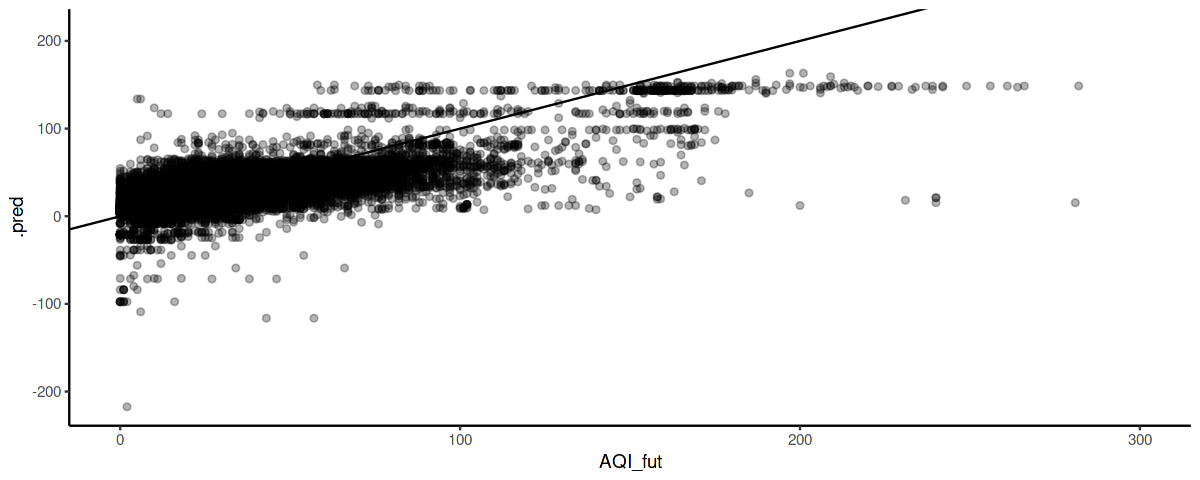

In [362]:
library(modelr)
add_predictions(testing(aqi.split), fit.rf) %>% 
    unnest(cols=c(pred)) %>% 
    ggplot(aes(x=AQI_fut, y=.pred)) + geom_point(alpha=.3) + geom_abline(intercept=0, slope=1) +
    xlim(c(0, 300))
    

How good is this prediction? Let's compare to the simple linear model:

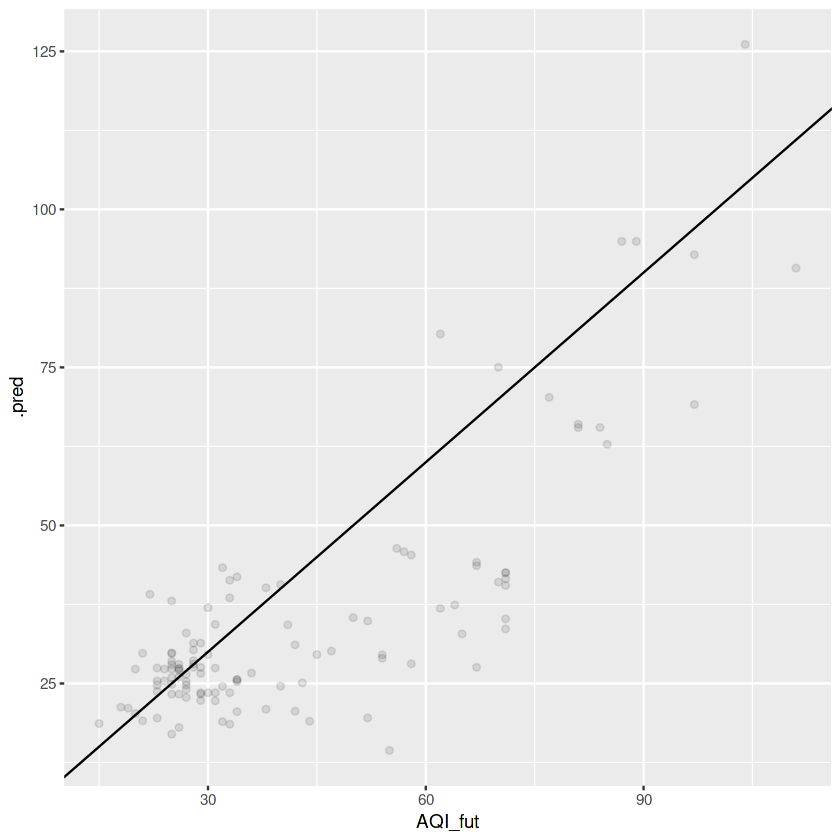

In [216]:
add_predictions(testing(aqi.split), fit.lm) %>% unnest(cols=c(pred)) %>% 
    ggplot(aes(x=AQI_fut, y=.pred)) + geom_point(alpha=.1) + geom_abline(intercept=0, slope=1)

And the boosted regression trees:

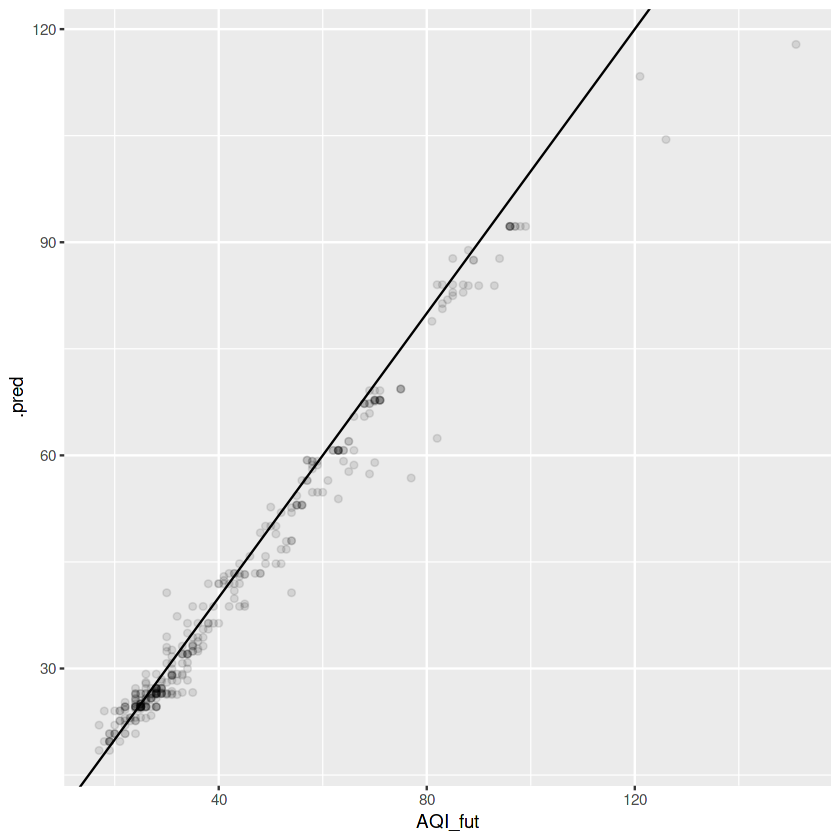

In [218]:
add_predictions(training(aqi.split), fit.bt) %>% unnest(cols=c(pred)) %>% 
    ggplot(aes(x=AQI_fut, y=.pred)) + geom_point(alpha=.1) + geom_abline(intercept=0, slope=1)

## Parameter tuning
Random forests have tuning parameters which can improve prediction performance, sometimes dramatically. 
The `tune` library can be used to automatune these parameters.

In [219]:
library(tune)
rf_tune <- rand_forest(trees = tune(), min_n=tune()) %>% 
  set_engine("ranger") %>% 
  set_mode("regression") %>% print

Random Forest Model Specification (regression)

Main Arguments:
  trees = tune()
  min_n = tune()

Computational engine: ranger 



If we try to run this model immediately, it won't work:

In [220]:
workflow() %>% add_model(rf_tune) %>% add_recipe(aqi.rec) %>% fit(training(aqi.split)) %>% print

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'print': Error: Invalid value for num.trees.


We will use brute force to tune the two parameters, `trees` and `min_n`:

In [221]:
tree_grid <- grid_regular(min_n(), trees(), levels = 3) %>% print

# A tibble: 9 × 2
  min_n trees
  <int> <int>
1     2     1
2    21     1
3    40     1
4     2  1000
5    21  1000
6    40  1000
7     2  2000
8    21  2000
9    40  2000


## Resampling
To do parameter tuning, we will use $k$-fold cross-validation:

In [222]:
library(rsample)
aqi.folds <- vfold_cv(training(aqi.split))
tree_wf <- workflow() %>% 
    add_model(rf_tune) %>% 
    add_recipe(aqi.rec)

# a2.tune <- tree_wf %>% tune_grid(resamples=a2.folds, grid=tree_grid)   # slooowwww

## Parallelization
Grid search hyperparameter tuning is sloooowwww--but also embarassingly parallel.

In [227]:
library(doFuture)
library(parallel)
all_cores <- parallel::detectCores(logical = FALSE)

library(doFuture)
registerDoFuture()
cl <- makeCluster(all_cores)
plan(cluster, workers = cl)

Loading required package: foreach


Attaching package: ‘foreach’


The following objects are masked from ‘package:purrr’:

    accumulate, when




In [238]:
aqi.tune <- tree_wf %>% tune_grid(resamples=aqi.folds, grid=tree_grid)  # fast

The best performing predictions are:

In [239]:
show_best(aqi.tune, metric="rmse")

trees,min_n,.metric,.estimator,mean,n,std_err,.config
<int>,<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2000,2,rmse,standard,6.212290,10,0.8016086,Preprocessor1_Model7
1000,2,rmse,standard,6.223077,10,0.8018902,Preprocessor1_Model4
1000,21,rmse,standard,7.968748,10,0.7331474,Preprocessor1_Model5
2000,21,rmse,standard,7.970815,10,0.7316430,Preprocessor1_Model8
1,2,rmse,standard,9.541870,10,1.1231501,Preprocessor1_Model1


In [240]:
best <- select_best(aqi.tune)
rf_best <- rand_forest(trees = best$trees, min_n=best$min_n) %>% 
  set_engine("ranger") %>% 
  set_mode("regression") %>% print

Warning message:
“No value of `metric` was given; metric 'rmse' will be used.”


Random Forest Model Specification (regression)

Main Arguments:
  trees = best$trees
  min_n = best$min_n

Computational engine: ranger 



In [241]:
best_rf <- workflow() %>% 
    add_model(rf_best) %>% 
    add_recipe(aqi.rec) %>% 
    fit(data=training(aqi.split)) 

test_pred <- best_rf %>% 
    add_predictions(testing(aqi.split), .) %>% 
    unnest(cols=pred)

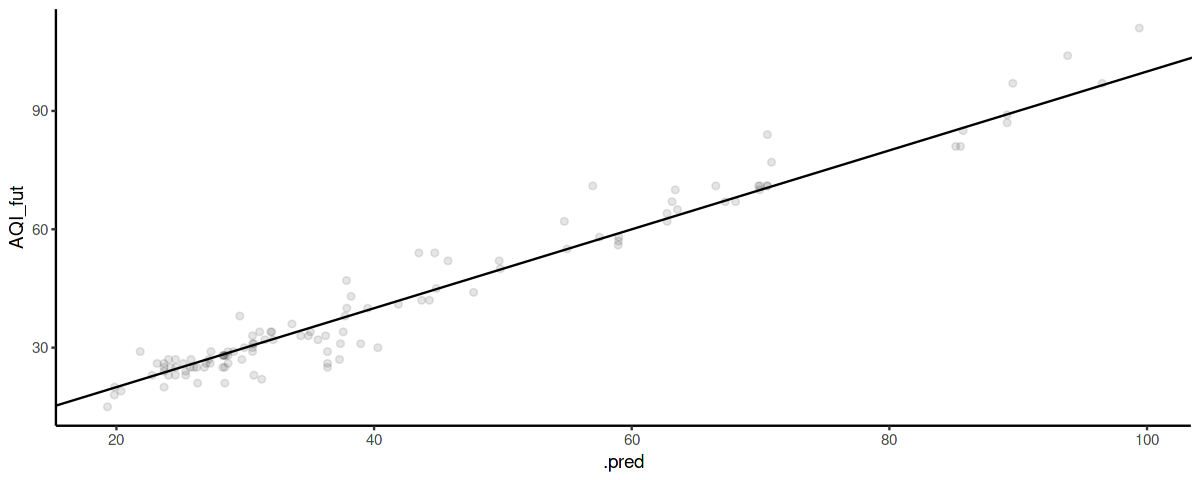

In [243]:
ggplot(test_pred) + geom_point(aes(x=.pred, y=AQI_fut), alpha=.1) + geom_abline(slope=1, intercept=0)